## MNIST KMeans Clustering and XGBoost Classification with Sagemaker PySpark

#### Project 3 - IDS 721 | Duke University 

### Malcolm Smith Fraser

In this project I leverage the Sagemaker architechrute to run distributed KMeans Clustering, and XGBoost classification on the MNIST dataset.

### 1) Configure Spark to use the Sagemaker PySpark dependency jars and cofigure the PySpark session

In [10]:
import os
import boto3

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

In [57]:
role = get_execution_role()

In [19]:
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()
    
spark

### 2) Load the Sagemaker MNIST sample data into Spark

In [12]:
import boto3

In [13]:
region = boto3.Session().region_name
spark._jsc.hadoopConfiguration().set('fs.s3a.endpoint', 's3.{}.amazonaws.com'.format(region))

In [14]:
trainingData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/train/'.format(region))

testData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/test/'.format(region))

trainingData.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  5.0|(784,[152,153,154...|
|  0.0|(784,[127,128,129...|
|  4.0|(784,[160,161,162...|
|  1.0|(784,[158,159,160...|
|  9.0|(784,[208,209,210...|
|  2.0|(784,[155,156,157...|
|  1.0|(784,[124,125,126...|
|  3.0|(784,[151,152,153...|
|  1.0|(784,[152,153,154...|
|  4.0|(784,[134,135,161...|
|  3.0|(784,[123,124,125...|
|  5.0|(784,[216,217,218...|
|  3.0|(784,[143,144,145...|
|  6.0|(784,[72,73,74,99...|
|  1.0|(784,[151,152,153...|
|  7.0|(784,[211,212,213...|
|  2.0|(784,[151,152,153...|
|  8.0|(784,[159,160,161...|
|  6.0|(784,[100,101,102...|
|  9.0|(784,[209,210,211...|
+-----+--------------------+
only showing top 20 rows



### 3) Kmeans Clustering of the MNIST Data using the Sagemaker PySpark estimator

In [15]:
from sagemaker_pyspark import IAMRole
from sagemaker_pyspark.algorithms import KMeansSageMakerEstimator
from sagemaker_pyspark import RandomNamePolicyFactory

In [25]:
kmeans_estimator = KMeansSageMakerEstimator(
    sagemakerRole = IAMRole(role),
    trainingInstanceType = 'ml.m4.xlarge',
    trainingInstanceCount = 1,
    endpointInstanceType = 'ml.t2.large', 
    endpointInitialInstanceCount = 1,
    namePolicyFactory = RandomNamePolicyFactory("ids721-"))


In [26]:
kmeans_estimator.setK(10)
kmeans_estimator.setFeatureDim(784)

kmeans_model = kmeans_estimator.fit(trainingData)

In [28]:
transformed_data = kmeans_model.transform(testData)
transformed_data.show()

+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  7.0|(784,[202,203,204...|   1426.73486328125|            1.0|
|  2.0|(784,[94,95,96,97...|   2040.19482421875|            5.0|
|  1.0|(784,[128,129,130...|  926.2728881835938|            8.0|
|  0.0|(784,[124,125,126...| 1635.2947998046875|            0.0|
|  4.0|(784,[150,151,159...| 1455.5211181640625|            2.0|
|  1.0|(784,[156,157,158...|  818.8414306640625|            8.0|
|  4.0|(784,[149,150,151...| 1681.6446533203125|            1.0|
|  9.0|(784,[179,180,181...|  1672.801513671875|            2.0|
|  5.0|(784,[129,130,131...|     2068.654296875|            2.0|
|  9.0|(784,[209,210,211...| 1523.4683837890625|            1.0|
|  0.0|(784,[123,124,125...|  1537.544189453125|            0.0|
|  6.0|(784,[94,95,96,97...| 1869.3433837890625|            7.0|
|  9.0|(784,[208,209,210.

### 4) Evaluate the KMeans clustering

In [29]:
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import numpy as np
import string

In [30]:
def showImage(img, caption='', xlabel='', subplot=None):
    """
    Takes the array of the transformed digit and reshapes it into a 28x28 image we can visualize
    """
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    digit=img.reshape((28,28))
    subplot.axes.get_xaxis().set_ticks([])
    subplot.axes.get_yaxis().set_ticks([])
    plt.title(caption)
    plt.xlabel(xlabel)
    subplot.imshow(digit, cmap='gray')

def displayClusters(data):
    """
    Plots the clusters determined by the KMeans algorithm
    """
    images = np.array(data.select("features").cache().take(250))
    clusters = data.select("closest_cluster").cache().take(250)

    for cluster in range(10):
        print(f'\n\n\nCluster {string.ascii_uppercase[cluster]}:')
        digits = [ img for l, img in zip(clusters, images) if int(l.closest_cluster) == cluster ]
        height=((len(digits)-1)//5)+1
        width=5
        plt.rcParams["figure.figsize"] = (width,height)
        _, subplots = plt.subplots(height, width)
        subplots=np.ndarray.flatten(subplots)
        for subplot, image in zip(subplots, digits):
            showImage(image, subplot=subplot)
        for subplot in subplots[len(digits):]:
            subplot.axis('off')

        plt.show()




Cluster A:


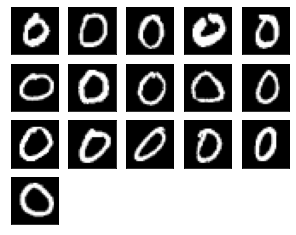




Cluster B:


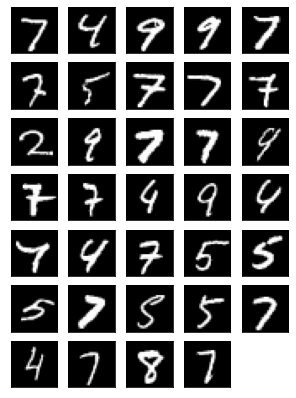




Cluster C:


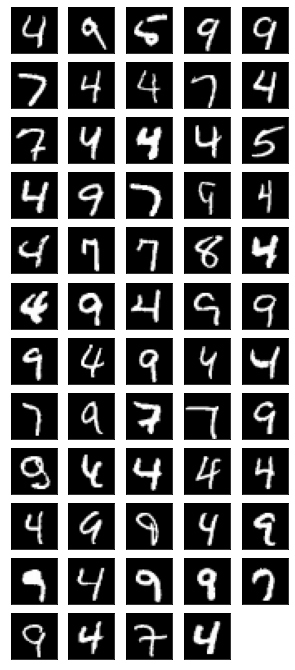




Cluster D:


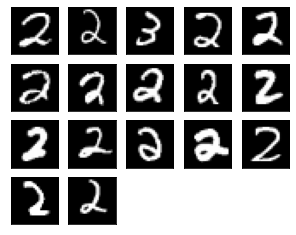




Cluster E:


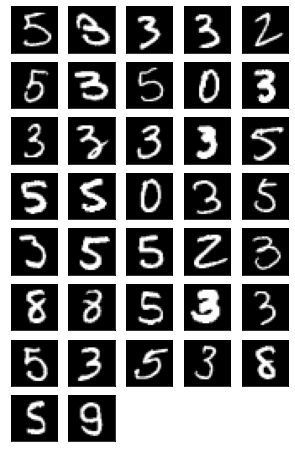




Cluster F:


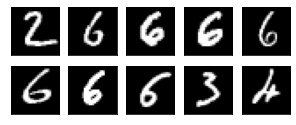




Cluster G:


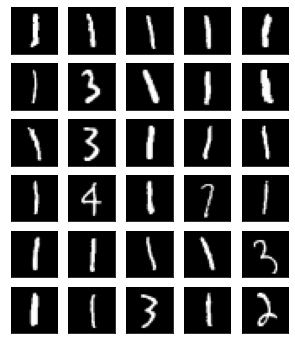




Cluster H:


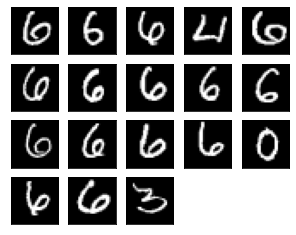




Cluster I:


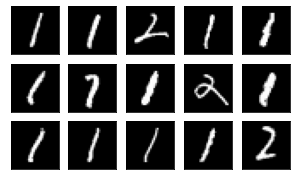




Cluster J:


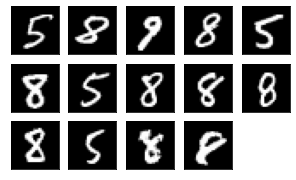

In [31]:
displayClusters(transformed_data)

### 5) Use XGBoost to classify the MNIST data

In [32]:
from sagemaker_pyspark.algorithms import XGBoostSageMakerEstimator

In [34]:
xgboost_estimator = XGBoostSageMakerEstimator(
    sagemakerRole = IAMRole(role),
    trainingInstanceType="ml.m4.xlarge", # Instance type to train k-means on
    trainingInstanceCount=1,
    endpointInstanceType="ml.m4.xlarge", # Endpoint for model
    endpointInitialInstanceCount=1,
    namePolicyFactory = RandomNamePolicyFactory("ids721-"))

xgboost_estimator.setObjective('multi:softmax')
xgboost_estimator.setNumRound(25)
xgboost_estimator.setNumClasses(10)

In [35]:
xg_boost_model = xgboost_estimator.fit(trainingData)

In [37]:
xg_transformed_data = xg_boost_model.transform(testData)
xg_transformed_data.show()

+-----+--------------------+----------+
|label|            features|prediction|
+-----+--------------------+----------+
|  7.0|(784,[202,203,204...|       7.0|
|  2.0|(784,[94,95,96,97...|       2.0|
|  1.0|(784,[128,129,130...|       1.0|
|  0.0|(784,[124,125,126...|       0.0|
|  4.0|(784,[150,151,159...|       4.0|
|  1.0|(784,[156,157,158...|       1.0|
|  4.0|(784,[149,150,151...|       4.0|
|  9.0|(784,[179,180,181...|       9.0|
|  5.0|(784,[129,130,131...|       5.0|
|  9.0|(784,[209,210,211...|       9.0|
|  0.0|(784,[123,124,125...|       0.0|
|  6.0|(784,[94,95,96,97...|       6.0|
|  9.0|(784,[208,209,210...|       9.0|
|  0.0|(784,[152,153,154...|       0.0|
|  1.0|(784,[125,126,127...|       1.0|
|  5.0|(784,[124,125,126...|       5.0|
|  9.0|(784,[179,180,181...|       9.0|
|  7.0|(784,[200,201,202...|       7.0|
|  3.0|(784,[118,119,120...|       3.0|
|  4.0|(784,[158,159,185...|       4.0|
+-----+--------------------+----------+
only showing top 20 rows



### 6) Evaluate the XGBoost predictions

#### First lets look at the what the model predicted

In [38]:
def displayPred(data):
    """
    Plots the predictions determined by the XGBoost algorithm
    """
    images = np.array(data.select("features").cache().take(250))
    preds = data.select("prediction").cache().take(250)

    for pred in range(10):
        print(f'\n\n\nModel predicted {pred}:')
        digits = [ img for l, img in zip(preds, images) if int(l.prediction) == pred ]
        height=((len(digits)-1)//5)+1
        width=5
        plt.rcParams["figure.figsize"] = (width,height)
        _, subplots = plt.subplots(height, width)
        subplots=np.ndarray.flatten(subplots)
        for subplot, image in zip(subplots, digits):
            showImage(image, subplot=subplot)
        for subplot in subplots[len(digits):]:
            subplot.axis('off')

        plt.show()




Model predicted 0:


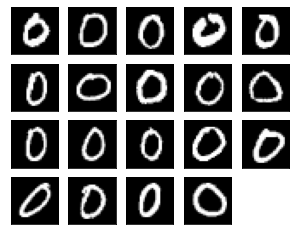




Model predicted 1:


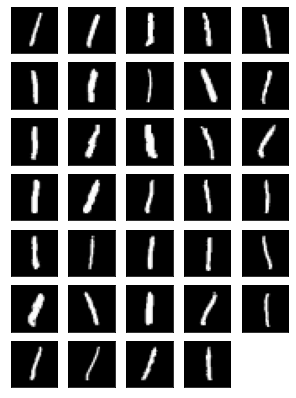




Model predicted 2:


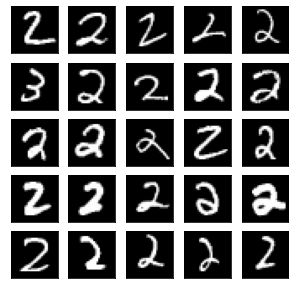




Model predicted 3:


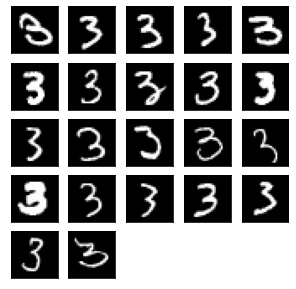




Model predicted 4:


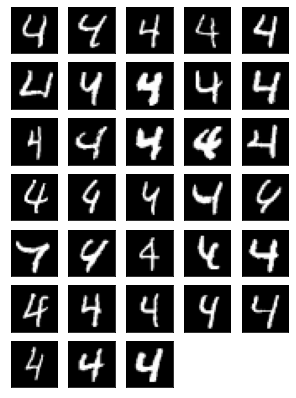




Model predicted 5:


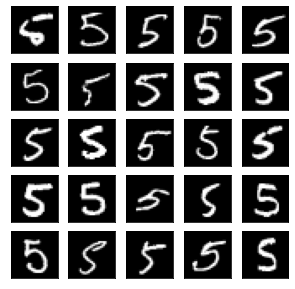




Model predicted 6:


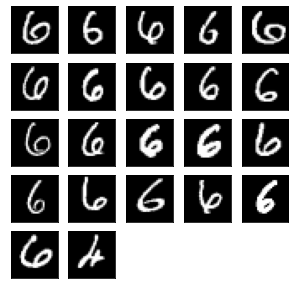




Model predicted 7:


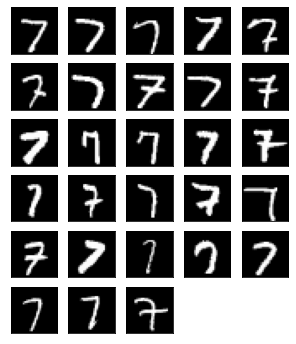




Model predicted 8:


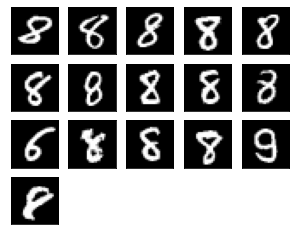




Model predicted 9:


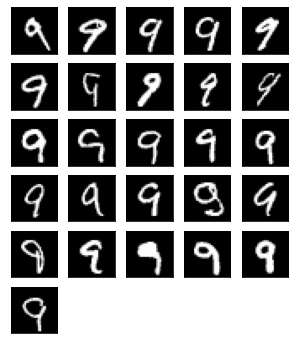

In [39]:
displayPred(xg_transformed_data)

#### Now lets evaluate some classification metrics

In [40]:
import pandas as pd
from pyspark.mllib.evaluation import MulticlassMetrics

In [41]:
predictionAndLabels = xg_boost_model.transform(testData).select('label', 'prediction')
metrics = MulticlassMetrics(predictionAndLabels.rdd.map(lambda x: tuple(map(float, x))))

confusion_matrix = metrics.confusionMatrix().toArray()
labels = [int(l) for l in metrics.call('labels')]

In [42]:
confusion_matrix = pd.DataFrame(confusion_matrix , index=labels, columns=labels)
print("MNIST XGBoost Confusion Matrix")
confusion_matrix

MNIST XGBoost Confusion Matrix


,0,1,2,3,4,5,6,7,8,9
0,966.0,1.0,6.0,1.0,2.0,3.0,10.0,1.0,4.0,7.0
1,1.0,1119.0,0.0,0.0,0.0,0.0,3.0,5.0,2.0,6.0
2,1.0,4.0,989.0,9.0,3.0,2.0,0.0,22.0,3.0,3.0
3,0.0,2.0,10.0,967.0,1.0,15.0,0.0,2.0,10.0,6.0
4,0.0,0.0,4.0,0.0,941.0,1.0,5.0,1.0,2.0,9.0
5,3.0,0.0,0.0,6.0,0.0,846.0,7.0,0.0,4.0,4.0
6,3.0,3.0,2.0,3.0,5.0,9.0,927.0,0.0,5.0,0.0
7,1.0,1.0,9.0,11.0,1.0,5.0,1.0,976.0,3.0,2.0
8,5.0,5.0,10.0,9.0,4.0,8.0,5.0,3.0,930.0,7.0
9,0.0,0.0,2.0,4.0,25.0,3.0,0.0,18.0,11.0,965.0


In [43]:
print('XGBoost Classification Metrics:\n')
print(f'Accuracy: {metrics.accuracy}')
print(f'Recall: {metrics.recall()}')
print(f'Precision: {metrics.precision()}')
print(f'F1-Score: {metrics.fMeasure()}')

XGBoost Classification Metrics:

Accuracy: 0.9626
Recall: 0.9626
Precision: 0.9626
F1-Score: 0.9626


### 7) Clean up Sagemaker endpoints, models, etc...

In [ ]:
from sagemaker_pyspark import SageMakerResourceCleanup

def cleanUp(model):
    resource_cleanup = SageMakerResourceCleanup(model.sagemakerClient)
    resource_cleanup.deleteResources(model.getCreatedResources())

# Don't forget to include any models or pipeline models that you created in the notebook
models = [kmeans_model, retrievedModel, modelFromJob, xg_boost_model]

# Delete regular SageMakerModels
for m in models:
    cleanUp(m)